In [1]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
#vimport tensorflow_addons as tfa
import tensorflow as tf
import numpy as np


import tensorflow

In [2]:
import numpy as np
# load data
data = np.load('loc/datloc.npy')
relative_list = np.load('loc/relativelist.npy')
e_stlat = np.load('loc/stlat.npy')
e_stlong = np.abs(np.load('loc/stlon.npy'))
evlat = np.load('loc/evlat.npy')
evlon = np.abs(np.load('loc/evlon.npy'))

relative_list[:,0] = e_stlat - evlat
relative_list[:,1] = e_stlong - evlon
relative_list[:,2] = relative_list[:,2]/1000
np.shape(data), np.shape(relative_list)


((13475, 5000, 3), (13475, 3))

In [3]:
# Normalize Depth
d= relative_list[0:,2]
min_d = np.min(d)
max_d = np.max(d)
normalized_d = (d - min_d) / (max_d - min_d)
relative_list3 = np.copy(relative_list)
relative_list3[:,2] = normalized_d


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras import backend
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import DepthwiseConv1D
# imports for backwards namespace compatibility
# pylint: disable=unused-import
# pylint: enable=unused-import
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export

In [6]:
dropout= 0.1
def activation_block(x):
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout != 0.0:
        x = layers.Dropout(dropout)(x)
    return x


def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv1D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = DepthwiseConv1D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv1D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x


def get_conv_mixer_256_8(



    image_size=5000, filters=512, depth=10, kernel_size=13, patch_size=10, num_classes=3  #
    
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, 3))
    #x = layers.Rescaling(scale=1.0 / 255)(inputs)
    #x = (inputs)

    # Extract patch embeddings.
    x = conv_stem(inputs, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="linear")(x)

    model = tensorflow.keras.Model(inputs, outputs)

    return model


In [8]:
# Code reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/.

# Test index
ix = int(len(data)*0.9)

def run_experiment(model):
    

    model.compile(
        optimizer=tensorflow.keras.optimizers.Adam(lr=0.001),
        loss= ['mse'],
        metrics= ['mse'],
    )

    checkpoint_filepath = "TX_bestmodelConvMix4.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        verbose=1,
        monitor="val_loss",mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=25, restore_best_weights=True
    )

    history = model.fit(
        data[0:ix], relative_list3[0:ix], batch_size=16,validation_split=0.0625 ,
        epochs=300, shuffle=False,
        callbacks=[checkpoint_callback,early_stopping],
    )

    #model.load_weights(checkpoint_filepath)
    #_, accuracy = model.evaluate(test_dataset)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, model

In [9]:
conv_mixer_model = get_conv_mixer_256_8()
conv_mixer_model.summary()

2023-09-22 21:21:35.022777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 21:21:36.125864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9277 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 500, 512)     15872       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 500, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 500, 512)     0           ['batch_normalization[0][0]']

 batch_normalization_7 (BatchNo  (None, 500, 512)    2048        ['depthwise_conv1d_3[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 500, 512)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 dropout_7 (Dropout)            (None, 500, 512)     0           ['activation_7[0][0]']           
                                                                                                  
 add_3 (Add)                    (None, 500, 512)     0           ['dropout_7[0][0]',              
                                                                  'dropout_6[0][0]']              
                                                                                                  
 conv1d_4 

 dropout_14 (Dropout)           (None, 500, 512)     0           ['activation_14[0][0]']          
                                                                                                  
 depthwise_conv1d_7 (DepthwiseC  (None, 500, 512)    7168        ['dropout_14[0][0]']             
 onv1D)                                                                                           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 500, 512)    2048        ['depthwise_conv1d_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 activation_15 (Activation)     (None, 500, 512)     0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 dropout_1

In [10]:
history, conv_mixer_model = run_experiment(conv_mixer_model)

/root/anaconda3/envs/tf-gpu-39/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300


2023-09-22 21:21:44.517007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-09-22 21:21:45.680169: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-09-22 21:21:45.724938: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


711/711 [==============================] - ETA: 0s - loss: 0.0591 - mse: 0.0591
Epoch 1: val_loss improved from inf to 0.01398, saving model to TX_bestmodelConvMix4.h5
711/711 [==============================] - 79s 98ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 2/300
711/711 [==============================] - ETA: 0s - loss: 0.0460 - mse: 0.0460
Epoch 2: val_loss did not improve from 0.01398
711/711 [==============================] - 70s 99ms/step - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 3/300
711/711 [==============================] - ETA: 0s - loss: 0.0425 - mse: 0.0425
Epoch 3: val_loss improved from 0.01398 to 0.01272, saving model to TX_bestmodelConvMix4.h5
711/711 [==============================] - 70s 99ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 4/300
711/711 [==============================] - ETA: 0s - loss: 0.0388 - mse: 0.0388
Epoch 4: val_loss did not improve from 0.01272
7

711/711 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 30: val_loss did not improve from 0.00458
711/711 [==============================] - 69s 97ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 31/300
711/711 [==============================] - ETA: 0s - loss: 0.0054 - mse: 0.0054
Epoch 31: val_loss did not improve from 0.00458
711/711 [==============================] - 69s 97ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 32/300
711/711 [==============================] - ETA: 0s - loss: 0.0052 - mse: 0.0052
Epoch 32: val_loss improved from 0.00458 to 0.00427, saving model to TX_bestmodelConvMix4.h5
711/711 [==============================] - 69s 98ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 33/300
711/711 [==============================] - ETA: 0s - loss: 0.0049 - mse: 0.0049
Epoch 33: val_loss did not improve from 0.00427
711/711 [==========================

Epoch 60/300
711/711 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028
Epoch 60: val_loss improved from 0.00297 to 0.00297, saving model to TX_bestmodelConvMix4.h5
711/711 [==============================] - 69s 97ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 61/300
711/711 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028
Epoch 61: val_loss did not improve from 0.00297
711/711 [==============================] - 69s 97ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 62/300
711/711 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030
Epoch 62: val_loss did not improve from 0.00297
711/711 [==============================] - 68s 96ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 63/300
711/711 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027
Epoch 63: val_loss did not improve from 0.00297
711/711 [=============

711/711 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 90: val_loss did not improve from 0.00286
711/711 [==============================] - 68s 96ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 91/300
711/711 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0017
Epoch 91: val_loss did not improve from 0.00286
711/711 [==============================] - 69s 97ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 92/300
711/711 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016
Epoch 92: val_loss did not improve from 0.00286
711/711 [==============================] - 69s 97ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 93/300
711/711 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015
Epoch 93: val_loss did not improve from 0.00286
711/711 [==============================] - 69s 97ms/step - loss: 0.0015 - mse: 0

Epoch 121/300
711/711 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011
Epoch 121: val_loss did not improve from 0.00276
711/711 [==============================] - 69s 97ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0029 - val_mse: 0.0029


In [11]:
model1 = get_conv_mixer_256_8()

#checkpoint_filepath = "/tmp/checkpoint_ct40"
model1.load_weights('TX_bestmodelConvMix4.h5')

In [12]:
# Test set [ix:]
out = model1.predict(data[ix:],verbose=1)
denormalized_d1 = out[:,2] * (max_d - min_d) + min_d

#np.save('out_conv_mixer_Valid',out)

43/43 [==============================] - 2s 29ms/step


Text(0, 0.5, 'Count ')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


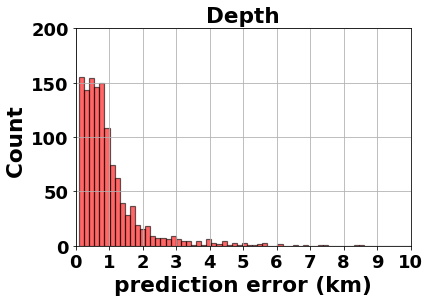

In [13]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.style.use('seaborn-deep')

fig = plt.figure()
fig_size = plt.gcf().get_size_inches()
#plt.gcf().set_size_inches(fig_size * [1.5, 1])

bins = np.linspace(0.1, 60.74, 400)
diff3 = np.abs(denormalized_d1 - relative_list[ix:,2])
np.save('err_dep',diff3)

plt.grid(True)

plt.hist(diff3,bins, color='red', alpha=0.6,edgecolor='black',linewidth=1.2)
plt.xlim([0, 10])
#plt.ylim([-3, 3])
#plt.yticks(np.arange(-3, 3, 0.5))
plt.xticks(np.arange(0, 10.1, 1))
plt.ylim(0, 200)


plt.title('Depth',fontsize='large', fontweight='bold')
plt.xlabel('prediction error (km)',fontsize='large', fontweight='bold')
plt.ylabel('Count ',fontsize='large', fontweight='bold')

#fig.savefig('Fig3(g).pdf', bbox_inches='tight', transpernt=True, dpi=100)
#fig.savefig('Fig3(g).png', bbox_inches='tight', transpernt=True, dpi=100)

In [14]:
# Reconstruct the Lat and Long
e_stlat1= e_stlat[ix:]
e_stlong1= e_stlong[ix:]
predict_lat = out[:,0]
predict_long = out[:,1]

eq_lat = e_stlat1- predict_lat
eq_long = e_stlong1- predict_long


In [15]:
import obspy
c=[]
dd = evlat[ix:]
dd1 = evlon[ix:]
distall=[]
for i in range(0,len(dd)):
    #mae = np.mean(np.abs(outtest[i]-dd[i]))
    #mae1 = np.mean(np.abs(outtest1[i]-dd1[i]))
    #if (mae<=0.1) and (mae1<=0.1):
    dis = obspy.geodetics.base.gps2dist_azimuth(dd[i],dd1[i],eq_lat[i],eq_long[i])
    #print(dis[0]/1000)
    distall.append(dis[0]/1000)

In [18]:
np.mean(diff3)

0.93949715349811869

Text(0, 0.5, 'Count ')

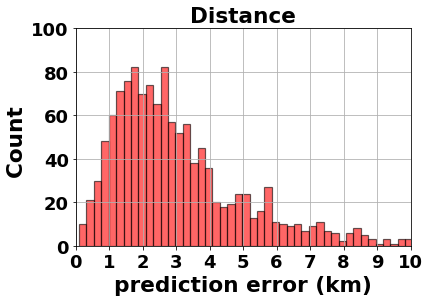

In [16]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.style.use('seaborn-deep')

fig = plt.figure()
fig_size = plt.gcf().get_size_inches()
#plt.gcf().set_size_inches(fig_size * [1.5, 1])

bins = np.linspace(0.1, 110.6, 500)
diff4 = np.array(distall)
plt.grid(True)

plt.hist(diff4,bins, color='red', alpha=0.6,edgecolor='black',linewidth=1.2)
plt.xlim([0, 10])
#plt.ylim([-3, 3])
#plt.yticks(np.arange(-3, 3, 0.5))
plt.xticks(np.arange(0, 10.1, 1))
plt.ylim(0, 100)

plt.title('Distance',fontsize='large', fontweight='bold')
plt.xlabel('prediction error (km)',fontsize='large', fontweight='bold')
plt.ylabel('Count ',fontsize='large', fontweight='bold')

#fig.savefig('Fig3(h).pdf', bbox_inches='tight', transpernt=True, dpi=100)
#fig.savefig('Fig3(h).png', bbox_inches='tight', transpernt=True, dpi=100)